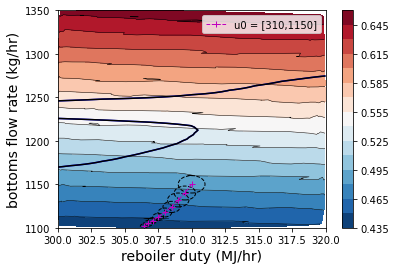

In [7]:
import os
from sklearn.utils.fixes import linspace
import win32com.client as win32
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy
from scipy.optimize import minimize
from scipy.optimize import Bounds
from sklearn.metrics import mean_squared_error
import pdb
import pandas as pd
import matplotlib.tri as tri
from sklearn.model_selection import train_test_split
import random
from scipy.optimize import fsolve
from matplotlib.patches import Ellipse
from matplotlib.pyplot import figure
np.random.seed(0)
np.set_printoptions(precision=6)

aspen_data = pd.read_excel(r'C:\Users\Massli\Desktop\4th_yr_lab\excel\Aspen_Data_49.xlsx',sheet_name='Sheet6',engine='openpyxl')

#import input data

df=pd.DataFrame(aspen_data)
abd=df.sample(n = 54)


reb = abd["reb"].values.reshape(-1,1) * 1000
bot= abd["bottoms"].values.reshape(-1,1) 


X = np.hstack((reb,bot))

#import output data
Y1 = abd["obj"].values.reshape(-1,1)
Y2 = abd["const"].values.reshape(-1,1)

#split up training and test data
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y1, test_size=0.5, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y2, test_size=0.5, random_state=10)

#Generate linear regression model based on data from Aspen
eta_1 =0.2
eta_2 =0.8

gamma_red =0.8
gamma_inc = 1.2

trr_both = np.array([2.5,30])#not sure

max_trr_u1 = 5 
max_trr_u2 = 60
max_trr_both = np.array([max_trr_u1,max_trr_u2])

mew_y1=0
mew_y2=0

model = LinearRegression().fit(X1_train, y1_train)
r_sq = model.score(X1_train, y1_train)
#print('coefficient of determination:obj', r_sq)

model1 = LinearRegression().fit(X2_train, y2_train)
r_sq1 = model1.score(X2_train, y2_train)
#print('coefficient of determination:cons', r_sq1)


# #Predict
obj_pred = model.predict(X1_train)
obj_const = model1.predict(X1_train)
obj_pred_test = model.predict(X1_test)
obj_const_test = model1.predict(X1_test)



##Initial model info

initial_guess1 = np.array([1, 1, 1])

u0=np.array([310,1250]) # some value that is good in our range
u_previous= u0
u=u0
d = np.array([2,-20])
# avg_Y1 = 0 #initial value of GP modifier
# avg_Y2 = 0

#Train Hyperparameters

def Kij(U,hyperparameters):
    lambdaa=np.diagflat(hyperparameters[1:3])
    noise_variance=0.001
    deltafun = noise_variance * np.identity(len(U))
    store_ker = np.zeros((len(U),len(U)))
    for i in range(len(U)):
        for j in range(len(U)):
            diffuu1 = U[i]-U[j] 
            diffuu1 = diffuu1.reshape(2,1)
            diffuu = diffuu1.T
            diffuu = diffuu.reshape(1,2)
            m= hyperparameters[0] * np.exp(-0.5* (diffuu @ lambdaa @ diffuu1))
            store_ker[i,j] = m
    KU = store_ker + deltafun
    return KU

def NLL(hyperparameters,u,dely): #objective function  
    neglog = 0.5 * np.log(scipy.linalg.det(Kij(u,hyperparameters))) + 0.5* np.linalg.multi_dot([dely,np.linalg.pinv(Kij(u,hyperparameters)),dely.T]) 
    return neglog[0]

y2_train=np.transpose(y2_train)


#Train GP for  Y2
hyp1 = np.linspace(0,1,100)
hyp2 = np.linspace(0,1,100)
hyp3 = np.linspace(0,1,100)
test =np.vstack([hyp1,hyp2,hyp3]).reshape(100,3)
localsol = np.zeros((100,3)) 
localval = np.zeros((100,1)) 
hypopt = np.zeros((0,3))
localval = np.zeros((100))
#print(np.shape(hyperparameters1))
#print(np.shape(test[1]))
for i in range(30):
  #minimizes the NLL to calculate optimla hyperparaameters for U->delY1
  arguments1 = (X1_train,y2_train)
  bounds1 = ((0.01,5),(0.01,5),(0.01,5))
  hypinit = np.array(test[i])
  Optimiser_y2= minimize(NLL, hypinit,bounds = bounds1,args=arguments1)
  localsol[i] = Optimiser_y2.x
  #localsol = np.vstack((localsol,localsol[i]))
  localval[i] = Optimiser_y2.fun

  
minindex = np.argmin(localval)
hypopt = localsol[minindex]
hyperparameters4 = hypopt


#print("NLL best",NLL(hyperparameters4,X1_train,y2_train))
#print("NLL init",NLL(initial_guess1 ,X1_train,y2_train))


# arguments4 = (X1_train,y2_train)
# bounds1 = ((0,10),(0,10),(0,10))
# Optimiser_y2= minimize(NLL, initial_guess1,bounds = bounds1,args=arguments4)
# hyperparameters4 = Optimiser_y2.x



## For objective: y1m = model.predict(u)
def y1_m(u):
    noise = np.random.normal(0, 0.001, [len(u),1])
    #print("noise", noise)
    y1m =  model.predict(u) + noise
    return y1m[0]

## for constraint: y2m = model1.predict(u)
##Calculate difference between model and Aspen
delY1= (y1_m(X1_train) - y1_train).reshape(1,len(X1_train))
#delY2 = (y2_m(X1_train) - y2_train).reshape(1,len(X1_train))
delY1_test= (y1_m(X1_test)-y1_test).reshape(1,len(X1_test))
##delY2_test = (y2_m(X1_test) - y2_test).reshape(1,len(X1_test))
y2_test=np.transpose(y2_test) # 1,len(x_test)
y1_test=np.transpose(y1_test)

arguments1 = (X1_test,delY1_test)
bounds1 = ((0,10),(0,10),(0,10))
Optimiser_dely1= minimize(NLL, initial_guess1,bounds = bounds1,args=arguments1)
hyperparameters1 = Optimiser_dely1.x



##define GP Prediction function
def GP_test_function(u,U,hyperparameters,delY1):
    covmag=hyperparameters[0]# SIGMA N  not squered
    lambdaa=np.diagflat(hyperparameters[1:3])
    store_KU = np.zeros((len(U),len(U)))
    store_ruU=np.zeros(len(U))
    noise_variance=0.001
    deltafun = noise_variance * np.identity(len(U))

    #calculate KUU
    for i in range(len(U)):
        for j in range(len(U)):
            diffuu1 = U[i]-U[j] #this gives us a 1 by 2 array
            diffuu1 = diffuu1.reshape(2,1)
            diffuu = diffuu1.T
            m= covmag**2 * np.exp(-0.5* np.linalg.multi_dot([diffuu, lambdaa, diffuu1]))
            store_KU[i,j] = m
    KU = store_KU + deltafun
    #print(KU,'KU')

    #calculate ruU
    for i in range(len(U)):
        diffuu1 = u-U[i] 
        diffuu1 = diffuu1.reshape(2,1)
        diffuu = diffuu1.T
        m= covmag**2 * np.exp(-0.5* np.linalg.multi_dot([diffuu, lambdaa, diffuu1]))
        store_ruU[i] = m
    ruU = store_ruU
    ruU_t=ruU.T

    #calculate posterior mean and sd
    KU_inv=np.linalg.pinv(KU)
    meanfunction_val = np.linalg.multi_dot([ruU_t,KU_inv,delY1.T])
    sdfunction_val = covmag**2-np.linalg.multi_dot([ruU_t,KU_inv,ruU])    
    
    return meanfunction_val



def y2_m(u,X1_test,hyperparameters4,y2_test):
    noise = np.random.normal(0, 0.0001, [len(u),1])
    y2m = GP_test_function(u,X1_test,hyperparameters4,y2_test) #+ noise
    #y2m =  model1.predict(u)  + noise
    return y2m


##Test GP performance
Test_U1 = np.array(np.linspace(303,319,10))
Test_U2 = np.array(np.linspace(1123,1341,10))
Test_U  = np.vstack((Test_U1,Test_U2)).reshape(10,2)
uz = np.array([320,1197])


y1m_test = np.empty((0,1))
y2m_test = np.empty((0,1))

for i in range(len(X1_test)):
    y1_m2_val = y1_m(X1_test[i].reshape(1, -1))
    y1m_test = np.vstack((y1m_test,y1_m2_val))
y1m_test = y1m_test.reshape(1,len(X1_test))  

#print("y1_test",y1_test)

for i in range(len(X1_test)):
    y2_m2_val = y2_m(X1_test[i].reshape(1, -1),X1_train,hyperparameters4,y2_train)
    y2m_test = np.vstack((y2m_test,y2_m2_val))
y2m_test = y2m_test.reshape(1,len(X1_test))  

y1m2_arr = np.empty((0,1))
for i in range(len(X1_test)):
    y1_m2 = y1_m(X1_test[i].reshape(1, -1))# + GP_test_function(u,X1_test,hyperparameters1,delY1_test)
    y1m2_arr = np.vstack((y1m2_arr,y1_m2))
y1m2_arr = y1m2_arr.reshape(1,len(X1_test))  
#print(y1m2_arr,"y1m2_arr")


def y1_m2(d,u,mew_y1,mew_y2,X1_test,delY1_test,delY2_test,y2_test,hyperparameters1,hyperparameters4): #objective function where A is lambda and epsilon
     
    print("d",d)
    u = u+d
    print("u",u)
    #print("delY1_test",delY1_test)
    mew_y1 = GP_test_function(u,X1_test,hyperparameters1,delY1_test)
    #print(mew_y1,"mew_y1")
    y1m2 = y1_m(u.reshape(1,2)) + mew_y1
    #print("y1m2",y1m2)
    return y1m2



def y2_m2(d,u,mew_y1,mew_y2,X1_test,delY1_test,delY2_test,y2_test,hyperparameters1,hyperparameters4): #MA constraint 
    u=u+d 
    #print("u",u)
    #mew_y2 = GP_test_function(u,X1_test,hyperparameters4,delY2_test)
    y2m2 = y2_m(u.reshape(1,2),X1_test,hyperparameters4,y2_test) #+ mew_y2#+0.01#+ mew_y2 
    #print("y2m2",y2m2)
    return y2m2

#create storage arrray/lists
store_kern = []
y2 = np.empty((0,1),int)

h_vap=2065.8
eta=0.53 
alpha=1/2.77777E-4 
p_elec=50/1000
p=42/1016.04691

def merit_func(d,u,u_previous,mew_y1):
  u = np.array(u)
  u_previous = np.array(u_previous)
  y1_mcurr = y1_m(u.reshape(1,2)) + mew_y1
  y1_mprev = y1_m(u_previous.reshape(1,2)) + mew_y1
  merit = ( y1_m(u_previous.reshape(1,2)) - y1_m(u.reshape(1,2))) /(y1_mprev - y1_mcurr)
  return merit

delY1_test=y1m_test-y1_test
delY2_test=y2m_test-y2_test

#Optimize

# for i in range(10):
#     print(i)
#     #arguments1 = (X1_test,delY2_test,hyperparameters2)
#     arguments  = (u,mew_y1,mew_y2,X1_test,delY1_test,delY2_test,y2_test,hyperparameters1,hyperparameters4)
#     con1 = {'type':'ineq','fun':y2_m2,'args':arguments} 
#     bnds = ((-trr_both[0],trr_both[0] ),(-trr_both[1],trr_both[1] ))

#     res = minimize(y1_m2,d,args = arguments,method='SLSQP',constraints=con1,tol =1e-3,options=None ,bounds=bnds)
#     d = res.x
#     store_kern.append(list(u))
#     u=u+d
    
#     #obj and const
#     aspen = win32.Dispatch('Apwn.Document')
#     aspen.InitFromArchive2(os.path.abspath(r'C:\Users\Massli\Desktop\4th_yr_lab\aspen\aspenfinalv1.bkp'))
#     aspen.Tree.FindNode(r'\Data\Blocks\E100\Input\QN').Value=u[0]
#     aspen.Tree.FindNode(r'\Data\Blocks\E101\Input\BASIS_B').Value=u[1]
#     aspen.Engine.Run2()
#     CO2=np.round(aspen.Tree.FindNode(r"\Data\Streams\313\Output\MASSFLOW\MIXED\CO2").Value,3)
#     print(CO2,'co2')
#     flow_j101=u[1]#flow 205
#     print( flow_j101,' flow_j101')
#     flow_j100=np.round(aspen.Tree.FindNode(r'\Data\Streams\208\Output\MASSFLMX\MIXED').Value,3)#flow 208
#     print( flow_j100,' flow_j100')
#     g2=-aspen.Tree.FindNode(r'\Data\Streams\108\Output\MOLEFRAC\MIXED\CO2').Value+0.02
#     flow_steam=np.round((u[0]*1000/h_vap),3)
#     pump_j100=np.round((((flow_j101)/250)*0.14*2.2*p_elec),3)
#     pump_j101=np.round((((flow_j100)/250)*0.14*2.2*p_elec),3)
#     C_pump=pump_j100+pump_j101
#     C_steam=((flow_steam)*h_vap*eta*p_elec)/alpha
#     C_cap=np.round((CO2*p),3)
#     g1=np.round((C_steam-C_cap+C_pump),3)
#     aspen.Close()

#     mew_y1 = GP_test_function(u,X1_test,hyperparameters1,delY1_test)
#     mew_y2 = GP_test_function(u,X1_test,hyperparameters4,delY2_test)

#     #y1_m(u.reshape(1,2))
#     #y2_m(u.reshape(1,2),X1_test,hyperparameters4,y2_test)
#     print(res.success)
#     if res.success == False or y2_m(u.reshape(1,2),X1_test,hyperparameters4,y2_test)<0 :
#         if (trr_both < max_trr_both).all():
#             trr_both = gamma_red * trr_both #*trr_prev [gamma_red,1]
#             print ('fgvdr')
#         else:
#             print ('fgbsrgrsgrgrgrgregvdr')
#             trr_both = trr_both
#         u = store_kern[-1] #'if infeasbile skip from here to.... where i pointed out below' #elif  ##Check infeasibility by calculating rho and update trust region
#     else: #1
#         if merit_func(d,u,store_kern[-1],mew_y1) > eta_2 and d[0] == trr_both[0] and d[1] == trr_both[1]:
#             if (trr_both < max_trr_both).all():
#                 trr_both =gamma_inc*trr_both #*trr_prev
#             else:
#                 trr_both = trr_both 
#             u = u
#         elif merit_func(d,u,store_kern[-1],mew_y1)< eta_1:
#             trr_both = trr_both * gamma_red
#             u = store_kern[-1]
#         else:
#             trr_both = trr_both
#             u = u    

#     #Update Input data if u is different
#     if (u != np.array(store_kern[-1])).all():
#         X1_test = np.vstack((X1_test,u))
#         y1_test = np.append(y1_test,g1)
#         y2_test = np.append(y2_test,g2)
#         y1m_testk = y1_m(u.reshape(1,2))
#         y2m_testk = y2_m(u.reshape(1,2),X1_test,hyperparameters4,y2_test)
#         y1m_test = np.append(y1m_test,y1m_testk)
#         y2m_test = np.append(y2m_test,y2m_testk)

#     delY1_test = (y1m_test - y1_test).reshape(1,len(X1_test))
#     delY2_test = (y2m_test - y2_test).reshape(1,len(X1_test))

# print(store_kern)
# X1=np.linspace(300, 320, 100)
# X2=np.linspace(1100, 1350, 100)
# print(np.shape(X1))
# print(np.shape(X2))
# triang = tri.Triangulation(X1, X2)
# print(np.shape(triang), "triang")
# npts = 100

# def plot_y1_m2(X1,X2):#,U_test,delY1_test,hyperparameters1): #objective function where A is lambda and epsilon
#     X1=X1.reshape(-1,1)
#     X2=X2.reshape(-1,1)
#     store = np.zeros((len(X1),len(X1)))
#     print(np.shape(store), 'store')
#     for i in range(len(X1)):
#         for j in range(len(X1)):
#             u = np.array([X1[i],X2[j]]).T
#             #print(np.shape(u),'u')
#             y1m2 = y1_m(u) #GP_test_function(u,U_test,hyperparameters1,delY1_test)
#             store[i,j] = y1m2
#     obj_y1 = store
#     print(np.shape(obj_y1), "obj")
#     return obj_y1
fig, ax = plt.subplots(subplot_kw={'aspect': 'auto'})
#figure(figsize=(8, 6), dpi=80)
npts = 1000
ngridx = 100
ngridy = 200
x = np.random.uniform(300, 320, npts)
y = np.random.uniform(1100, 1350, npts)
x = x.reshape(len(x),)
y = y.reshape(len(x),)
def plot_y1_m2(x,y):
    x=x.reshape(-1,1)
    y=y.reshape(-1,1)
    store = np.zeros([len(x),1])
    for i in range(len(x)): 
        u = np.array([x[i],y[i]]).T
        y1m2 = y1_m(u) 
        store[i] = y1m2
    obj_y1 = store
    return obj_y1

z = plot_y1_m2(x,y).reshape(len(x),)
#fig,  ax2 = plt.subplots(nrows=2)

# # -----------------------
# # Interpolation on a grid
# # -----------------------
# # A contour plot of irregularly spaced data coordinates
# # via interpolation on a grid.

# # Create grid values first.
xi = np.linspace(297.5, 322.5, ngridx)
yi = np.linspace(1095, 1355, ngridy)
#ax = plt
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
# ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
X1 = np.linspace(300, 320, 50)
X2 = np.linspace(1100, 1350, 50)

X11, X22 = np.meshgrid(X1,X2)
def plot_y2_m2(X1,X2,X2_test,hyperparameters4,y2_test):
    store = np.zeros((len(X1),len(X1)))
    for i in range(len(X1)):
         for j in range(len(X1)):
             u = np.array([X1[j],X2[i]])
             y2m2 = y2_m(u.reshape(1,2),X2_test,hyperparameters4,y2_test)
             store[i,j] = y2m2
    obj_y2 = store
    return obj_y2

Z2 = plot_y2_m2(X1,X2,X2_test,hyperparameters4,y2_test)
cs1= ax.contour(X1, X2, Z2 ,colors='blue',levels=[0])
fig.colorbar(cntr1, ax=ax)
# ax1.plot(x, y, 'ko', ms=3)
ax.set(xlim=(300, 320), ylim=(1100, 1350))
# ax.set_title('grid and contour (%d points, %d grid points)' %
#               (npts, ngridx * ngridy))

ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

#ax.colorbar(cntr2, ax=ax)
#ax.plot(x, y, 'ko', ms=3)
#ax.title('tricontour (%d points)' % npts)
ax.contour(X1,X2,Z2,levels=[0], colors='k')
#levels=[-0.03,-0.02,0,0.02,0.03,1]
u_colab=[[310, 1225],[308.68665482918135, 1220.7717525787073], [307.48665482918136, 1204.0435051574145], [306.52818291342624, 1188.1039103871874], [305.76018291342626, 1175.3039103871874], [305.1457829134263, 1165.0639103871874], [304.6542629134263, 1156.9028424731052], [304.26181491468134, 1150.3620424940223], [303.94785651570874, 1145.1294025111456], [303.6971808364371, 1140.951474523285], [303.4958542444371, 1137.596031323285], [304.493413, 1112.596031]]
u_colab=np.array(u_colab)
u_colab1=[[315,1300],[316.0, 1275.0], [316.9999999986838, 1255.0000000065859], [317.9599993175055, 1239.0000000065859], [318.72650074439866, 1226.2213329666042], [319.3397019130746, 1216.0213134862477], [319.83122191307456, 1207.8293134862477]]
u_colab1=np.array(u_colab1)
u_colab2=[[305,1175],[305.5, 1165.0146626345831], [305.9, 1155.0293252691663], [306.2992187413203, 1145.0650292686246], [306.69843748264066, 1135.1007332680829], [307.097656223961, 1125.1364372675412], [307.417656223961, 1115.5364372675413], [307.67315622117826, 1107.8564372675412], [307.92865621839553, 1100.1764372675411]] 
u_colab2=np.array(u_colab2)
u_colab3=[[315,1225],[314.5008831604988, 1215.002173667663], [314.1024468190272, 1204.9998518074942], [313.7824468190272, 1194.9975299473253], [313.4636910098505, 1185.0275188503877], [313.2076910098505, 1175.05750775345], [313.00289100985054, 1165.0874966565123], [312.83905100985055, 1156.8954966565123], [312.67521100985056, 1148.7034966565122], [312.51137100985056, 1140.5114966565122], [312.38029900985055, 1133.9578966565123], [312.24922700985053, 1127.4170966730353], [312.1443694098505, 1122.1742166730353], [312.0395118098505, 1116.9313366730353], [311.9556257298505, 1112.7370326730352], [311.88851686585053, 1109.381589473035], [311.83482977465053, 1106.6972349130351], [311.7811426834505, 1104.0128803530351], [311.73819301049053, 1101.8653967050352]]  
u_colab3=np.array(u_colab3)
u_colab4=[[305,1150],[304.5, 1140.0], [304.0, 1130.0], [303.6, 1120.0], [303.28000000000003, 1110.0], [303.02400000000006, 1100.0]] 
u_colab4=np.array(u_colab4)
u_colab5=[[310,1225],[311.0, 1215.0], [312.0, 1205.0], [312.8, 1195.0], [313.44, 1185.0], [313.952, 1175.0], [314.464, 1165.0], [314.976, 1155.0], [315.3856, 1145.0], [315.71328, 1136.808], [316.04096, 1128.616], [316.36863999999997, 1120.424], [316.63078399999995, 1113.8704], [316.84049919999995, 1108.62752],[ 317.050214, 1103.38464]]  
u_colab5=np.array(u_colab5)
u_colab6=[[310,1150],[309.49951172715475, 1140.0], [309.0002814301836, 1132.0000020887342], [308.50229913703987, 1124.0156246410459], [308.00417827771184, 1117.6281244936938], [307.50704386533, 1112.5181245017482], [307.0982438612665, 1108.4221245017482], [306.69022228733536, 1104.3314371763092], [306.28299320213625, 1100.2407688275161]]   
u_colab6=np.array(u_colab6)
u_colab7=[[310,1150],[309.5, 1140.0], [309.0, 1132.0], [308.5, 1124.0], [308.0, 1117.6], [307.5, 1112.48], [307.0904, 1108.384], [306.76272, 1105.1072], [306.43504, 1101.8303999999998]] 
u_colab7=np.array(u_colab7)
trr_colab=[[1.5,25],[1.2000000000000002, 20.0], [0.9600000000000002, 16.0], [0.7680000000000002, 12.8], [0.6144000000000003, 10.240000000000002], [0.49152000000000023, 8.192000000000002], [0.39321600000000023, 6.553600000000002], [0.3145728000000002, 5.242880000000002], [0.2516582400000002, 4.194304000000002], [0.20132659200000017, 3.3554432000000016], [0.16106127360000014, 2.6843545600000014], [0.093211,1.849595]] 
trr_colab=np.array(trr_colab)
trr_colab1=[[1.5,25],[1.2000000000000002, 20.0], [0.9600000000000002, 16.0], [0.7680000000000002, 12.8], [0.6144000000000003, 10.240000000000002], [0.49152000000000023, 8.192000000000002], [0.39321600000000023, 6.553600000000002]] 
trr_colab1=np.array(trr_colab1)
trr_colab2=[[0.5,15],[0.4, 12.0], [0.4, 12.0], [0.4, 12.0], [0.4, 12.0], [0.32000000000000006, 9.600000000000001], [0.25600000000000006, 7.6800000000000015], [0.25600000000000006, 7.6800000000000015], [0.25600000000000006, 7.6800000000000015]] 
trr_colab2=np.array(trr_colab2)
trr_colab3=[[0.5,25],[0.4, 20.0], [0.32000000000000006, 16.0], [0.32000000000000006, 16.0], [0.25600000000000006, 12.8], [0.20480000000000007, 10.240000000000002], [0.16384000000000007, 8.192000000000002], [0.16384000000000007, 8.192000000000002], [0.16384000000000007, 8.192000000000002], [0.13107200000000005, 6.553600000000002], [0.13107200000000005, 6.553600000000002], [0.10485760000000005, 5.242880000000002], [0.10485760000000005, 5.242880000000002], [0.08388608000000004, 4.194304000000002], [0.06710886400000003, 3.3554432000000016], [0.05368709120000003, 2.6843545600000014], [0.05368709120000003, 2.6843545600000014], [0.042949672960000025, 2.147483648000001], [0.042949672960000025, 2.147483648000001]] 
trr_colab3=np.array(trr_colab3)
trr_colab4=[[0.5,25],[0.5, 25.0], [0.4, 20.0], [0.32000000000000006, 16.0], [0.25600000000000006, 12.8], [0.25600000000000006, 12.8]] 
trr_colab4=np.array(trr_colab4)
trr_colab5=[[1,25],[1, 25], [0.8, 20.0], [0.6400000000000001, 16.0], [0.5120000000000001, 12.8], [0.5120000000000001, 12.8], [0.5120000000000001, 12.8], [0.40960000000000013, 10.240000000000002], [0.32768000000000014, 8.192000000000002], [0.32768000000000014, 8.192000000000002], [0.32768000000000014, 8.192000000000002], [0.2621440000000001, 6.553600000000002], [0.2097152000000001, 5.242880000000002], [0.2097152000000001, 5.242880000000002],[0.2097152000000001, 5.242880000000002]]   
trr_colab5=np.array(trr_colab5)
trr_colab6=[[1,10],[0.8, 8.0], [0.8, 8.0], [0.6400000000000001, 6.4], [0.5120000000000001, 5.120000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001]] 
trr_colab6=np.array(trr_colab6)
trr_colab7=[[1,10],[0.8, 8.0], [0.8, 8.0], [0.6400000000000001, 6.4], [0.5120000000000001, 5.120000000000001], [0.40960000000000013, 4.096000000000001], [0.32768000000000014, 3.276800000000001], [0.32768000000000014, 3.276800000000001], [0.2621440000000001, 2.621440000000001]]    
trr_colab7=np.array(trr_colab7)
#ax.plot(u_colab[:,0],u_colab[:,1],'k',linestyle='dashed', marker='o',label = "u0 = [310,1225]" ,linewidth=1)
#ax.plot(u_colab1[:,0],u_colab1[:,1],'m',linestyle='dashed', marker='d',label = "u0 = [315,1300]" ,linewidth=1)
#ax.plot(u_colab6[:,0],u_colab6[:,1],'c',linestyle='dashed', marker='+',label = "u0 = [310,1150]" ,linewidth=1)
ax.plot(u_colab7[:,0],u_colab7[:,1],'m',linestyle='dashed', marker='+',label = "u0 = [310,1150]" ,linewidth=1)
# ax.plot(u_colab4[:,0],u_colab4[:,1],'c',linestyle='dashed', marker='+',label = "u0 = [305,1150]" ,linewidth=1)
# ax.plot(u_colab5[:,0],u_colab5[:,1],'m',linestyle='dashed', marker='+',label = "u0 = [310,1225]" ,linewidth=1)
#for i in range(len(u_colab)):
  #e = Ellipse((u_colab[i,0],u_colab[i,1]),trr_colab[i,0]*2,trr_colab[i,1]*2,linestyle = '--',fill = False)
  #ax.add_artist(e)
#for i in range(len(u_colab1)):
  #e1 = Ellipse((u_colab1[i,0],u_colab1[i,1]),trr_colab1[i,0]*2,trr_colab1[i,1]*2,linestyle = '--',fill = False)
  #ax.add_artist(e1)
# for i in range(len(u_colab2)):
#  e2 = Ellipse((u_colab2[i,0],u_colab2[i,1]),trr_colab2[i,0]*2,trr_colab2[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e2)
# for i in range(len(u_colab3)):
#  e3 = Ellipse((u_colab3[i,0],u_colab3[i,1]),trr_colab3[i,0]*2,trr_colab3[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e3)
# for i in range(len(u_colab4)):
#  e4 = Ellipse((u_colab4[i,0],u_colab4[i,1]),trr_colab4[i,0]*2,trr_colab4[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e4)
# for i in range(len(u_colab5)):
#  e5 = Ellipse((u_colab5[i,0],u_colab5[i,1]),trr_colab5[i,0]*2,trr_colab5[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e5)
# for i in range(len(u_colab6)):
#  e6 = Ellipse((u_colab6[i,0],u_colab6[i,1]),trr_colab6[i,0]*2,trr_colab6[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e6)
for i in range(len(u_colab7)):
 e7 = Ellipse((u_colab7[i,0],u_colab7[i,1]),trr_colab7[i,0]*2,trr_colab7[i,1]*2,linestyle = '--',fill = False)
 ax.add_artist(e7)
ax.set_xlabel("reboiler duty (MJ/hr)",color="black",fontsize=14)
ax.set_ylabel("bottoms flow rate (kg/hr)",color="black",fontsize=14)
ax.legend(loc='best')


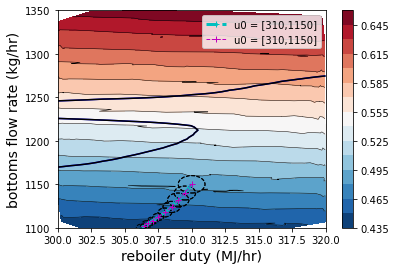

In [4]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'auto'})
#figure(figsize=(8, 6), dpi=80)
npts = 1000
ngridx = 100
ngridy = 200
x = np.random.uniform(300, 320, npts)
y = np.random.uniform(1100, 1350, npts)
x = x.reshape(len(x),)
y = y.reshape(len(x),)
def plot_y1_m2(x,y):
    x=x.reshape(-1,1)
    y=y.reshape(-1,1)
    store = np.zeros([len(x),1])
    for i in range(len(x)): 
        u = np.array([x[i],y[i]]).T
        y1m2 = y1_m(u) 
        store[i] = y1m2
    obj_y1 = store
    return obj_y1

z = plot_y1_m2(x,y).reshape(len(x),)
#fig,  ax2 = plt.subplots(nrows=2)

# # -----------------------
# # Interpolation on a grid
# # -----------------------
# # A contour plot of irregularly spaced data coordinates
# # via interpolation on a grid.

# # Create grid values first.
xi = np.linspace(297.5, 322.5, ngridx)
yi = np.linspace(1095, 1355, ngridy)
#ax = plt
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
# ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
X1 = np.linspace(300, 320, 50)
X2 = np.linspace(1100, 1350, 50)

X11, X22 = np.meshgrid(X1,X2)
def plot_y2_m2(X1,X2,X2_test,hyperparameters4,y2_test):
    store = np.zeros((len(X1),len(X1)))
    for i in range(len(X1)):
         for j in range(len(X1)):
             u = np.array([X1[j],X2[i]])
             y2m2 = y2_m(u.reshape(1,2),X2_test,hyperparameters4,y2_test)
             store[i,j] = y2m2
    obj_y2 = store
    return obj_y2

Z2 = plot_y2_m2(X1,X2,X2_test,hyperparameters4,y2_test)
cs1= ax.contour(X1, X2, Z2 ,colors='blue',levels=[0])
fig.colorbar(cntr1, ax=ax)
# ax1.plot(x, y, 'ko', ms=3)
ax.set(xlim=(300, 320), ylim=(1100, 1350))
# ax.set_title('grid and contour (%d points, %d grid points)' %
#               (npts, ngridx * ngridy))

ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

#ax.colorbar(cntr2, ax=ax)
#ax.plot(x, y, 'ko', ms=3)
#ax.title('tricontour (%d points)' % npts)
ax.contour(X1,X2,Z2,levels=[0], colors='k')
#levels=[-0.03,-0.02,0,0.02,0.03,1]
# u_colab=[[310, 1225],[308.68665482918135, 1220.7717525787073], [307.48665482918136, 1204.0435051574145], [306.52818291342624, 1188.1039103871874], [305.76018291342626, 1175.3039103871874], [305.1457829134263, 1165.0639103871874], [304.6542629134263, 1156.9028424731052], [304.26181491468134, 1150.3620424940223], [303.94785651570874, 1145.1294025111456], [303.6971808364371, 1140.951474523285], [303.4958542444371, 1137.596031323285], [304.493413, 1112.596031]]
# u_colab=np.array(u_colab)
# u_colab1=[[315,1300],[316.0, 1275.0], [316.9999999986838, 1255.0000000065859], [317.9599993175055, 1239.0000000065859], [318.72650074439866, 1226.2213329666042], [319.3397019130746, 1216.0213134862477], [319.83122191307456, 1207.8293134862477]]
# u_colab1=np.array(u_colab1)
# u_colab2=[[305,1175],[305.5, 1165.0146626345831], [305.9, 1155.0293252691663], [306.2992187413203, 1145.0650292686246], [306.69843748264066, 1135.1007332680829], [307.097656223961, 1125.1364372675412], [307.417656223961, 1115.5364372675413], [307.67315622117826, 1107.8564372675412], [307.92865621839553, 1100.1764372675411]] 
# u_colab2=np.array(u_colab2)
# u_colab3=[[315,1225],[314.5008831604988, 1215.002173667663], [314.1024468190272, 1204.9998518074942], [313.7824468190272, 1194.9975299473253], [313.4636910098505, 1185.0275188503877], [313.2076910098505, 1175.05750775345], [313.00289100985054, 1165.0874966565123], [312.83905100985055, 1156.8954966565123], [312.67521100985056, 1148.7034966565122], [312.51137100985056, 1140.5114966565122], [312.38029900985055, 1133.9578966565123], [312.24922700985053, 1127.4170966730353], [312.1443694098505, 1122.1742166730353], [312.0395118098505, 1116.9313366730353], [311.9556257298505, 1112.7370326730352], [311.88851686585053, 1109.381589473035], [311.83482977465053, 1106.6972349130351], [311.7811426834505, 1104.0128803530351], [311.73819301049053, 1101.8653967050352]]  
# u_colab3=np.array(u_colab3)
# u_colab4=[[305,1150],[304.5, 1140.0], [304.0, 1130.0], [303.6, 1120.0], [303.28000000000003, 1110.0], [303.02400000000006, 1100.0]] 
# u_colab4=np.array(u_colab4)
# u_colab5=[[310,1225],[311.0, 1215.0], [312.0, 1205.0], [312.8, 1195.0], [313.44, 1185.0], [313.952, 1175.0], [314.464, 1165.0], [314.976, 1155.0], [315.3856, 1145.0], [315.71328, 1136.808], [316.04096, 1128.616], [316.36863999999997, 1120.424], [316.63078399999995, 1113.8704], [316.84049919999995, 1108.62752],[ 317.050214, 1103.38464]]  
# u_colab5=np.array(u_colab5)
u_colab6=[[310,1150],[309.49951172715475, 1140.0], [309.0002814301836, 1132.0000020887342], [308.50229913703987, 1124.0156246410459], [308.00417827771184, 1117.6281244936938], [307.50704386533, 1112.5181245017482], [307.0982438612665, 1108.4221245017482], [306.69022228733536, 1104.3314371763092], [306.28299320213625, 1100.2407688275161]]   
u_colab6=np.array(u_colab6)
u_colab7=[[310,1150],[309.5, 1140.0], [309.0, 1132.0], [308.5, 1124.0], [308.0, 1117.6], [307.5, 1112.48], [307.0904, 1108.384], [306.76272, 1105.1072], [306.43504, 1101.8303999999998]] 
u_colab7=np.array(u_colab7)
# trr_colab=[[1.5,25],[1.2000000000000002, 20.0], [0.9600000000000002, 16.0], [0.7680000000000002, 12.8], [0.6144000000000003, 10.240000000000002], [0.49152000000000023, 8.192000000000002], [0.39321600000000023, 6.553600000000002], [0.3145728000000002, 5.242880000000002], [0.2516582400000002, 4.194304000000002], [0.20132659200000017, 3.3554432000000016], [0.16106127360000014, 2.6843545600000014], [0.093211,1.849595]] 
# trr_colab=np.array(trr_colab)
# trr_colab1=[[1.5,25],[1.2000000000000002, 20.0], [0.9600000000000002, 16.0], [0.7680000000000002, 12.8], [0.6144000000000003, 10.240000000000002], [0.49152000000000023, 8.192000000000002], [0.39321600000000023, 6.553600000000002]] 
# trr_colab1=np.array(trr_colab1)
# trr_colab2=[[0.5,15],[0.4, 12.0], [0.4, 12.0], [0.4, 12.0], [0.4, 12.0], [0.32000000000000006, 9.600000000000001], [0.25600000000000006, 7.6800000000000015], [0.25600000000000006, 7.6800000000000015], [0.25600000000000006, 7.6800000000000015]] 
# trr_colab2=np.array(trr_colab2)
# trr_colab3=[[0.5,25],[0.4, 20.0], [0.32000000000000006, 16.0], [0.32000000000000006, 16.0], [0.25600000000000006, 12.8], [0.20480000000000007, 10.240000000000002], [0.16384000000000007, 8.192000000000002], [0.16384000000000007, 8.192000000000002], [0.16384000000000007, 8.192000000000002], [0.13107200000000005, 6.553600000000002], [0.13107200000000005, 6.553600000000002], [0.10485760000000005, 5.242880000000002], [0.10485760000000005, 5.242880000000002], [0.08388608000000004, 4.194304000000002], [0.06710886400000003, 3.3554432000000016], [0.05368709120000003, 2.6843545600000014], [0.05368709120000003, 2.6843545600000014], [0.042949672960000025, 2.147483648000001], [0.042949672960000025, 2.147483648000001]] 
# trr_colab3=np.array(trr_colab3)
# trr_colab4=[[0.5,25],[0.5, 25.0], [0.4, 20.0], [0.32000000000000006, 16.0], [0.25600000000000006, 12.8], [0.25600000000000006, 12.8]] 
# trr_colab4=np.array(trr_colab4)
# trr_colab5=[[1,25],[1, 25], [0.8, 20.0], [0.6400000000000001, 16.0], [0.5120000000000001, 12.8], [0.5120000000000001, 12.8], [0.5120000000000001, 12.8], [0.40960000000000013, 10.240000000000002], [0.32768000000000014, 8.192000000000002], [0.32768000000000014, 8.192000000000002], [0.32768000000000014, 8.192000000000002], [0.2621440000000001, 6.553600000000002], [0.2097152000000001, 5.242880000000002], [0.2097152000000001, 5.242880000000002],[0.2097152000000001, 5.242880000000002]]   
# trr_colab5=np.array(trr_colab5)
trr_colab6=[[1,10],[0.8, 8.0], [0.8, 8.0], [0.6400000000000001, 6.4], [0.5120000000000001, 5.120000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001], [0.40960000000000013, 4.096000000000001]] 
trr_colab6=np.array(trr_colab6)
trr_colab7=[[1,10],[0.8, 8.0], [0.8, 8.0], [0.6400000000000001, 6.4], [0.5120000000000001, 5.120000000000001], [0.40960000000000013, 4.096000000000001], [0.32768000000000014, 3.276800000000001], [0.32768000000000014, 3.276800000000001], [0.2621440000000001, 2.621440000000001]]    
trr_colab7=np.array(trr_colab7)
#ax.plot(u_colab[:,0],u_colab[:,1],'k',linestyle='dashed', marker='o',label = "u0 = [310,1225]" ,linewidth=1)
#ax.plot(u_colab1[:,0],u_colab1[:,1],'m',linestyle='dashed', marker='d',label = "u0 = [315,1300]" ,linewidth=1)
ax.plot(u_colab6[:,0],u_colab6[:,1],'c',linestyle='dashed', marker='+',label = "u0 = [310,1150]" ,linewidth=3)
ax.plot(u_colab7[:,0],u_colab7[:,1],'m',linestyle='dashed', marker='+',label = "u0 = [310,1150]" ,linewidth=1)
# ax.plot(u_colab4[:,0],u_colab4[:,1],'c',linestyle='dashed', marker='+',label = "u0 = [305,1150]" ,linewidth=1)
# ax.plot(u_colab5[:,0],u_colab5[:,1],'m',linestyle='dashed', marker='+',label = "u0 = [310,1225]" ,linewidth=1)
#for i in range(len(u_colab)):
  #e = Ellipse((u_colab[i,0],u_colab[i,1]),trr_colab[i,0]*2,trr_colab[i,1]*2,linestyle = '--',fill = False)
  #ax.add_artist(e)
#for i in range(len(u_colab1)):
  #e1 = Ellipse((u_colab1[i,0],u_colab1[i,1]),trr_colab1[i,0]*2,trr_colab1[i,1]*2,linestyle = '--',fill = False)
  #ax.add_artist(e1)
# for i in range(len(u_colab2)):
#  e2 = Ellipse((u_colab2[i,0],u_colab2[i,1]),trr_colab2[i,0]*2,trr_colab2[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e2)
# for i in range(len(u_colab3)):
#  e3 = Ellipse((u_colab3[i,0],u_colab3[i,1]),trr_colab3[i,0]*2,trr_colab3[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e3)
# for i in range(len(u_colab4)):
#  e4 = Ellipse((u_colab4[i,0],u_colab4[i,1]),trr_colab4[i,0]*2,trr_colab4[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e4)
# for i in range(len(u_colab5)):
#  e5 = Ellipse((u_colab5[i,0],u_colab5[i,1]),trr_colab5[i,0]*2,trr_colab5[i,1]*2,linestyle = '--',fill = False)
#  ax.add_artist(e5)
for i in range(len(u_colab6)):
 e6 = Ellipse((u_colab6[i,0],u_colab6[i,1]),trr_colab6[i,0]*2,trr_colab6[i,1]*2,linestyle = '--',fill = False)
 ax.add_artist(e6)
for i in range(len(u_colab7)):
 e7 = Ellipse((u_colab7[i,0],u_colab7[i,1]),trr_colab7[i,0]*2,trr_colab7[i,1]*2,linestyle = '--',fill = False)
 ax.add_artist(e7)
ax.set_xlabel("reboiler duty (MJ/hr)",color="black",fontsize=14)
ax.set_ylabel("bottoms flow rate (kg/hr)",color="black",fontsize=14)
ax.legend(loc='best')

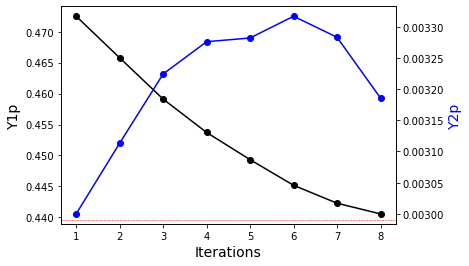

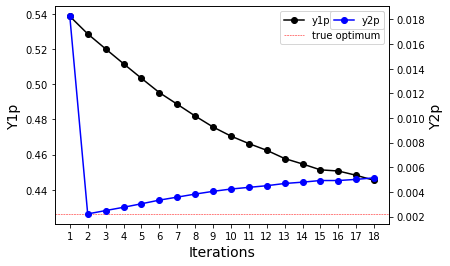

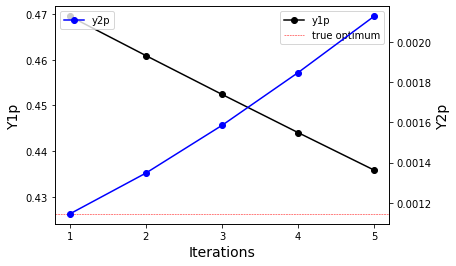

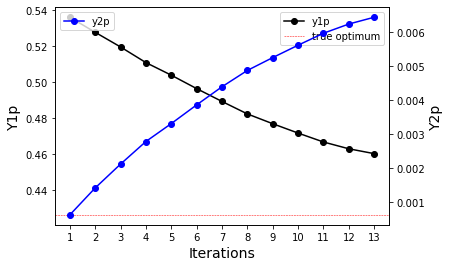

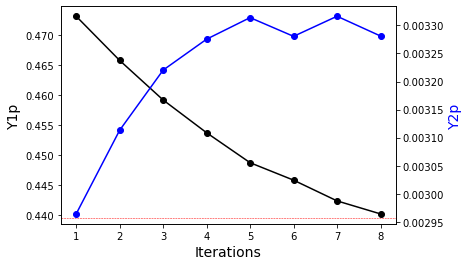

In [17]:
y1p_obj=[0.4912356798222773, 0.48279736187086747, 0.4745756149358951, 0.46613511701846644, 0.45878482257797576, 0.4515636806414809, 0.4459359534696881, 0.43992796763215813] 
y1p_obj1=[0.5386977607557233, 0.5286688110035624, 0.5201340840845555, 0.511702168497538, 0.5034040906216879, 0.49527492201966916, 0.48863744075028664, 0.4819545494212661, 0.4756859037863733, 0.47051544518055455, 0.46625265393037296, 0.46242264685883494, 0.45774475430272754, 0.4546507645947953, 0.45129233073449093, 0.45064491497051284, 0.4481922188614341, 0.44532861466556045]  
y1p_obj2=[0.46951365417945623, 0.4608997082240495, 0.45240307339026803, 0.4440355202081443, 0.43581878873115043] 
y1p_obj3=[0.536110948101378, 0.5277514027851308, 0.5196057204519022, 0.5109086215923087, 0.5039166655033577, 0.49645285074153434, 0.4893054515391403, 0.4823730310200629, 0.4769311992055224, 0.4717274702423453, 0.46677102993934017, 0.4629910225579484, 0.4602973063351169] 
y1p_obj4=[0.47250208956609197, 0.46578050941759996, 0.45911163480411654, 0.45371646029207113, 0.449318117934301, 0.44517332565920853, 0.4422777811592646, 0.4405474949051059] 
y1p_obj5=[0.4731600485791416, 0.4657795992481709, 0.45916889609288836, 0.45369089850673716, 0.4486833814822519, 0.44576946403419326, 0.4423030812437734, 0.44012722717469027] 

y2p_cons=[0.0005286308007885002, 0.0010839074767651988, 0.0016278129839332016, 0.0021847437042722996, 0.0026815549940625016, 0.0031428680979576004, 0.0035036795906433008, 0.0038851233031226007] 
y2p_cons1=[0.01825640366748858, 0.0022162729896860987, 0.0024876305428003995, 0.0027542477093506004, 0.0030390628185335, 0.0033355453409349006, 0.0035787139105199, 0.003824543105369199, 0.004047717506217602, 0.004235008701090101, 0.004370799693724701, 0.0045045750140628, 0.004684899428022601, 0.004792982513942801, 0.004926889690396601, 0.004924893392765001, 0.005019096058566201, 0.005145575040550701] 
y2p_cons2=[0.0011455550147835003, 0.0013482047324612015, 0.0015848853622721995, 0.0018468306182534006, 0.0021265244598147014] 
y2p_cons3=[0.0006257525580263996, 0.0014183766691063006, 0.002119852802621402, 0.0027847065129032005, 0.0033116358709399003, 0.0038617751399946006, 0.004395123680609301, 0.0048756350911701996, 0.0052533383532432, 0.005618185858566001, 0.0059696351397357, 0.0062407346934336, 0.0064407127092677] 
y2p_cons4=[0.0029999022167796, 0.0031132114619564014, 0.0032242085524328, 0.0032759894954545003, 0.003281989318830999, 0.0033168367004283994, 0.0032830927177699004, 0.0031855970408137015] 
y2p_cons5=[0.0029639802854348994, 0.0031131187542654017, 0.0032203617456236996, 0.0032755135010994994, 0.0033139430766900013, 0.003280569122360702, 0.003316393483680999, 0.0032811248029138013] 

iterations = list(range(1, 1+len(y1p_obj4)))
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(iterations,y1p_obj4, color="black", marker="o",label = "y1p")
# set x-axis label
plt.xticks(list(range(1, 1+len(y1p_obj4))))
ax.set_xlabel("Iterations",fontsize=14)
# set y-axis label
ax.set_ylabel("Y1p",color="black",fontsize=14)
plt.axhline(y=0.439526, color='r', linestyle='--',label = "true optimum",linewidth=0.5)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(iterations, y2p_cons4,color="blue",marker="o",label = "y2p")
ax2.set_ylabel("Y2p",color="blue",fontsize=14)
#ax.legend(loc='best')
#ax2.legend(loc='best')
plt.show()

iterations = list(range(1, 1+len(y1p_obj1)))
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(iterations,y1p_obj1, color="black", marker="o",label = "y1p")
# set x-axis label
plt.xticks(list(range(1, 1+len(y1p_obj1))))
ax.set_xlabel("Iterations",fontsize=14)
# set y-axis label
ax.set_ylabel("Y1p",color="black",fontsize=14)
plt.axhline(y=0.42623062565997266, color='r', linestyle='--',label = "true optimum",linewidth=0.5)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(iterations, y2p_cons1,color="blue",marker="o",label = "y2p")
ax2.set_ylabel("Y2p",color="black",fontsize=14)
ax.legend(loc='best')
ax2.legend(loc='best')
plt.show()

iterations = list(range(1, 1+len(y1p_obj2)))
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(iterations,y1p_obj2, color="black", marker="o",label = "y1p")
# set x-axis label
plt.xticks(list(range(1, 1+len(y1p_obj2))))
ax.set_xlabel("Iterations",fontsize=14)
# set y-axis label
ax.set_ylabel("Y1p",color="black",fontsize=14)
plt.axhline(y=0.42623062565997266, color='r', linestyle='--',label = "true optimum",linewidth=0.5)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(iterations, y2p_cons2,color="blue",marker="o",label = "y2p")
ax2.set_ylabel("Y2p",color="black",fontsize=14)
ax.legend(loc='best')
ax2.legend(loc='best')
plt.show()

iterations = list(range(1, 1+len(y1p_obj3)))
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(iterations,y1p_obj3, color="black", marker="o",label = "y1p")
# set x-axis label
plt.xticks(list(range(1, 1+len(y1p_obj3))))
ax.set_xlabel("Iterations",fontsize=14)
# set y-axis label
ax.set_ylabel("Y1p",color="black",fontsize=14)
plt.axhline(y=0.42623062565997266, color='r', linestyle='--',label = "true optimum",linewidth=0.5)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(iterations, y2p_cons3,color="blue",marker="o",label = "y2p")
ax2.set_ylabel("Y2p",color="black",fontsize=14)
ax.legend(loc='best')
ax2.legend(loc='best')
plt.show()

iterations = list(range(1, 1+len(y1p_obj5)))
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(iterations,y1p_obj5, color="black", marker="o",label = "y1p")
# set x-axis label
plt.xticks(list(range(1, 1+len(y1p_obj5))))
ax.set_xlabel("Iterations",fontsize=14)
# set y-axis label
ax.set_ylabel("Y1p",color="black",fontsize=14)
plt.axhline(y=0.439526, color='r', linestyle='--',label = "true optimum",linewidth=0.5)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(iterations, y2p_cons5,color="blue",marker="o",label = "y2p")
ax2.set_ylabel("Y2p",color="blue",fontsize=14)
#ax.legend(loc='best')
#ax2.legend(loc='best')
plt.show()



In [14]:
a=np.where(z==z.min())
print(z[a])


[0.439526]
